# OCR Evaluation Pipeline - AI Model Comparison

This notebook processes all compressed images, evaluates OCR accuracy using multiple vision models via OpenRouter, and generates results for the paper.

## Overview
- **Models**: Gemini 2.5 Pro, Claude Opus 4.5 Low, GPT-4o-mini (via OpenRouter)
- **Workflows**: EXCEL, GIT, JIRA, TEKKEN
- **Quality Levels**: PNG (original), JPEG q25, q5, q1
- **Evaluation**: Quantitative metrics (character/word accuracy) + Task-critical phrase detection

## Task-Critical Phrases
- **GIT**: ["Commit changes", "Push", "Pull", "Repository"]
- **JIRA**: ["Create", "Issue", "Project", "Summary", "Description"]
- **EXCEL**: ["File", "Home", "Insert", "Data", "Formula"]
- **TEKKEN**: ["Menu", "Start", "Options", "Character"]

## Setup Instructions
1. Install dependencies: `pip install -r requirements.txt`
2. Copy `.env.example` to `.env` and add your OpenRouter API key
3. Verify model names at [openrouter.ai/models](https://openrouter.ai/models) and update Cell 2 if needed

In [3]:
# Cell 1: Setup and imports
import os
import base64
import json
import time
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import difflib
from Levenshtein import distance as levenshtein_distance
from dotenv import load_dotenv
from openai import OpenAI

# Load environment variables
load_dotenv()

# Configure paths
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
RESULTS_DIR = BASE_DIR

# Define workflows and quality levels
WORKFLOWS = ["EXCEL", "GIT", "JIRA", "TEKKEN"]
QUALITY_LEVELS = ["PNG", 25, 5, 1]

# Task-critical phrases for each workflow
TASK_CRITICAL_PHRASES = {
    "GIT": ["Commit changes", "Push", "Pull", "Repository"],
    "JIRA": ["Create", "Issue", "Project", "Summary", "Description"],
    "EXCEL": ["File", "Home", "Insert", "Data", "Formula"],
    "TEKKEN": ["Menu", "Start", "Options", "Character"]
}

print("✓ Setup complete!")
print(f"Data directory: {DATA_DIR}")
print(f"Workflows: {WORKFLOWS}")
print(f"Quality levels: {QUALITY_LEVELS}")

✓ Setup complete!
Data directory: c:\Users\Matthew Feroz\Desktop\ALIVEOCR\ALIVEData\research\data
Workflows: ['EXCEL', 'GIT', 'JIRA', 'TEKKEN']
Quality levels: ['PNG', 25, 5, 1]


In [4]:
# Cell 2: OpenRouter Configuration
# Get your API key from https://openrouter.ai/keys

OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")

if not OPENROUTER_API_KEY:
    print("⚠️  No OPENROUTER_API_KEY found in environment!")
    print("Create a .env file with: OPENROUTER_API_KEY=your_key_here")
    print("Or set it directly below:")
    # OPENROUTER_API_KEY = "your_key_here"  # Uncomment and add your key
else:
    print(f"✓ OpenRouter API key loaded (ends with ...{OPENROUTER_API_KEY[-4:]})")

# Initialize OpenRouter client (OpenAI-compatible API)
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
)

# Models to compare - FAST models for OCR comparison
# Using confirmed working OpenRouter model IDs
MODELS = {
    "gemini-2.5-flash": "google/gemini-2.5-flash",          # Fast Gemini 2.5 Flash
    "claude-3.5-sonnet": "anthropic/claude-3.5-sonnet",     # Fast Claude model  
    "gpt-4o-mini": "openai/gpt-4o-mini",                    # Fastest OpenAI vision model
}

print(f"\n✓ Models configured:")
for name, model_id in MODELS.items():
    print(f"  - {name}: {model_id}")

✓ OpenRouter API key loaded (ends with ...a159)

✓ Models configured:
  - gemini-2.5-flash: google/gemini-2.5-flash
  - claude-3.5-sonnet: anthropic/claude-3.5-sonnet
  - gpt-4o-mini: openai/gpt-4o-mini


In [5]:
# Cell 3: Helper Functions

def encode_image_to_base64(image_path: Path) -> str:
    """Encode an image file to base64 string."""
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

def get_image_mime_type(image_path: Path) -> str:
    """Get MIME type based on file extension."""
    ext = image_path.suffix.lower()
    mime_types = {
        ".png": "image/png",
        ".jpg": "image/jpeg",
        ".jpeg": "image/jpeg",
        ".gif": "image/gif",
        ".webp": "image/webp"
    }
    return mime_types.get(ext, "image/png")

def get_image_path(workflow: str, image_num: int, quality) -> Path:
    """Get the path to an image file based on workflow, number, and quality."""
    if quality == "PNG":
        filename = f"{workflow}{image_num}.png"
    else:
        filename = f"{workflow}{image_num}_q{quality}.jpg"
    return DATA_DIR / workflow / filename

def list_available_images() -> Dict[str, List[Path]]:
    """List all available images organized by workflow."""
    images = {}
    for workflow in WORKFLOWS:
        workflow_dir = DATA_DIR / workflow
        if workflow_dir.exists():
            images[workflow] = sorted(workflow_dir.glob("*"))
    return images

# Test image listing
available = list_available_images()
print("✓ Available images:")
for workflow, files in available.items():
    print(f"  {workflow}: {len(files)} files")

✓ Available images:
  EXCEL: 16 files
  GIT: 16 files
  JIRA: 16 files
  TEKKEN: 16 files


In [6]:
# Cell 4: OCR Function using OpenRouter

OCR_PROMPT = """Extract ALL visible text from this image. 
Include every piece of text you can see - menu items, buttons, labels, titles, etc.
Return ONLY the extracted text, nothing else. Preserve the general layout where possible."""

# Maximum image dimension to avoid API limits
MAX_IMAGE_DIMENSION = 2048  # Resize if larger than this

# CACHE for preprocessed images - avoids re-processing same image for each model
_image_cache = {}

def prepare_image_for_api(image_path: Path, use_cache: bool = True) -> Tuple[str, str]:
    """
    Prepare an image for API submission - resize if needed and convert to base64.
    Uses caching to avoid re-processing the same image multiple times.
    
    Returns:
        Tuple of (base64_string, mime_type)
    """
    cache_key = str(image_path)
    
    # Return cached version if available
    if use_cache and cache_key in _image_cache:
        return _image_cache[cache_key]
    
    img = Image.open(image_path)
    
    # Resize if too large
    if max(img.size) > MAX_IMAGE_DIMENSION:
        ratio = MAX_IMAGE_DIMENSION / max(img.size)
        new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
        img = img.resize(new_size, Image.Resampling.LANCZOS)
    
    # Convert to RGB if needed (for JPEG compatibility)
    if img.mode == 'RGBA':
        background = Image.new('RGB', img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])
        img = background
    elif img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Save to bytes as JPEG (better compatibility with APIs)
    import io
    buffer = io.BytesIO()
    img.save(buffer, format='JPEG', quality=85)
    buffer.seek(0)
    base64_image = base64.b64encode(buffer.read()).decode('utf-8')
    
    # Cache the result
    result = (base64_image, "image/jpeg")
    if use_cache:
        _image_cache[cache_key] = result
    
    return result

def perform_ocr(image_path: Path, model_key: str, retry_count: int = 2) -> Tuple[str, float, Optional[str]]:
    """
    Perform OCR on an image using a specified model via OpenRouter.
    
    Returns:
        Tuple of (extracted_text, response_time_seconds, error_message)
    """
    model_id = MODELS[model_key]
    
    # Prepare image (uses cache - fast if already processed)
    base64_image, mime_type = prepare_image_for_api(image_path)
    
    for attempt in range(retry_count):
        try:
            start_time = time.time()
            
            response = client.chat.completions.create(
                model=model_id,
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "text",
                                "text": OCR_PROMPT
                            },
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:{mime_type};base64,{base64_image}"
                                }
                            }
                        ]
                    }
                ],
                max_tokens=2048,  # Reduced - OCR doesn't need 4k tokens
            )
            
            elapsed_time = time.time() - start_time
            extracted_text = response.choices[0].message.content
            
            return extracted_text, elapsed_time, None
            
        except Exception as e:
            error_msg = str(e)
            if attempt < retry_count - 1:
                time.sleep(1)  # Brief retry delay
            else:
                return "", 0.0, error_msg
    
    return "", 0.0, "Max retries exceeded"

print("✓ OCR function ready (with caching)")

✓ OCR function ready (with caching)


In [7]:
# Cell 5: Evaluation Metrics

def calculate_phrase_detection(text: str, workflow: str) -> Dict[str, bool]:
    """Check which task-critical phrases were detected in the OCR output."""
    phrases = TASK_CRITICAL_PHRASES.get(workflow, [])
    text_lower = text.lower()
    return {phrase: phrase.lower() in text_lower for phrase in phrases}

def calculate_phrase_accuracy(text: str, workflow: str) -> float:
    """Calculate the percentage of task-critical phrases detected."""
    detection = calculate_phrase_detection(text, workflow)
    if not detection:
        return 0.0
    return sum(detection.values()) / len(detection) * 100

def calculate_word_count(text: str) -> int:
    """Count the number of words in the text."""
    return len(text.split())

def calculate_char_count(text: str) -> int:
    """Count the number of characters (excluding whitespace)."""
    return len(text.replace(" ", "").replace("\n", ""))

def compare_texts(text1: str, text2: str) -> float:
    """Calculate similarity ratio between two texts using SequenceMatcher."""
    return difflib.SequenceMatcher(None, text1.lower(), text2.lower()).ratio() * 100

def calculate_levenshtein_similarity(text1: str, text2: str) -> float:
    """Calculate similarity using Levenshtein distance (normalized)."""
    if not text1 and not text2:
        return 100.0
    max_len = max(len(text1), len(text2))
    if max_len == 0:
        return 100.0
    dist = levenshtein_distance(text1.lower(), text2.lower())
    return (1 - dist / max_len) * 100

print("✓ Evaluation metrics ready")

✓ Evaluation metrics ready


In [8]:
# Cell 6: Batch Processing (with resume support)

RESULTS_FILE = RESULTS_DIR / "ocr_comparison_results.csv"

def load_existing_results() -> Tuple[pd.DataFrame, set]:
    """Load existing results and return completed task keys."""
    if RESULTS_FILE.exists():
        df = pd.read_csv(RESULTS_FILE)
        # Create set of completed tasks: (workflow, img_num, quality, model)
        completed = set()
        for _, row in df.iterrows():
            completed.add((row['workflow'], row['image_num'], row['quality'], row['model']))
        return df, completed
    return pd.DataFrame(), set()

def run_comparison(
    workflows: List[str] = None,
    quality_levels: List = None,
    models: List[str] = None,
    images_per_workflow: int = 4,
    resume: bool = True,
    verbose: bool = False
) -> pd.DataFrame:
    """
    Run OCR comparison across all specified configurations.
    
    Args:
        workflows: List of workflows to process (default: all)
        quality_levels: List of quality levels (default: all)
        models: List of model keys to use (default: all)
        images_per_workflow: Number of images per workflow (1-4)
        resume: If True, skip already-completed tasks from previous runs
        verbose: If True, print detailed progress
        
    Returns:
        DataFrame with all results
    """
    workflows = workflows or WORKFLOWS
    quality_levels = quality_levels or QUALITY_LEVELS
    models = models or list(MODELS.keys())
    
    # Load existing results if resuming
    existing_df, completed_tasks = (pd.DataFrame(), set())
    if resume:
        existing_df, completed_tasks = load_existing_results()
        if len(completed_tasks) > 0:
            print(f"📂 Resuming: {len(completed_tasks)} tasks already completed")
    
    results = existing_df.to_dict('records') if len(existing_df) > 0 else []
    
    # Calculate tasks
    all_tasks = []
    for workflow in workflows:
        for img_num in range(1, images_per_workflow + 1):
            for quality in quality_levels:
                for model_key in models:
                    task_key = (workflow, img_num, quality, model_key)
                    if task_key not in completed_tasks:
                        all_tasks.append((workflow, img_num, quality, model_key))
    
    if len(all_tasks) == 0:
        print("✅ All tasks already completed!")
        return pd.DataFrame(results)
    
    print(f"🚀 Running {len(all_tasks)} tasks...")
    errors = 0
    
    with tqdm(total=len(all_tasks), desc="Processing") as pbar:
        for workflow, img_num, quality, model_key in all_tasks:
            image_path = get_image_path(workflow, img_num, quality)
            
            if not image_path.exists():
                pbar.update(1)
                errors += 1
                continue
            
            pbar.set_description(f"{workflow}{img_num} q{quality} - {model_key}")
            
            # Get file size
            file_size_kb = image_path.stat().st_size / 1024
            
            text, response_time, error = perform_ocr(image_path, model_key)
            
            result = {
                "workflow": workflow,
                "image_num": img_num,
                "quality": quality,
                "model": model_key,
                "file_size_kb": round(file_size_kb, 2),
                "response_time_s": round(response_time, 2),
                "word_count": calculate_word_count(text),
                "char_count": calculate_char_count(text),
                "phrase_accuracy": calculate_phrase_accuracy(text, workflow),
                "extracted_text": text,
                "error": error
            }
            results.append(result)
            
            if error:
                errors += 1
                tqdm.write(f"⚠️ Error on {workflow}{img_num} q{quality} {model_key}: {error[:50]}...")
            
            # SAVE AFTER EVERY CALL (critical for recovery)
            pd.DataFrame(results).to_csv(RESULTS_FILE, index=False)
            
            pbar.update(1)
            time.sleep(0.1)  # Minimal rate limiting
    
    df = pd.DataFrame(results)
    print(f"\n✅ Complete! {len(df)} results saved to {RESULTS_FILE}")
    if errors > 0:
        print(f"⚠️  {errors} errors occurred")
    
    return df

print("✓ Batch processing function ready (with resume support)")

✓ Batch processing function ready (with resume support)


In [9]:
# Cell 7: PRE-FLIGHT CHECK - Verify all images exist before running
# This prevents wasted API calls due to missing files

print("=" * 60)
print("PRE-FLIGHT CHECK: Verifying all images exist")
print("=" * 60)

missing_images = []
found_images = []

for workflow in WORKFLOWS:
    for img_num in range(1, 5):  # 4 images per workflow
        for quality in QUALITY_LEVELS:
            image_path = get_image_path(workflow, img_num, quality)
            if image_path.exists():
                found_images.append(image_path)
            else:
                missing_images.append(image_path)

print(f"\n✓ Found: {len(found_images)} images")
print(f"✗ Missing: {len(missing_images)} images")

if missing_images:
    print("\n⚠️  MISSING IMAGES:")
    for p in missing_images[:10]:  # Show first 10
        print(f"  - {p}")
    if len(missing_images) > 10:
        print(f"  ... and {len(missing_images) - 10} more")
    print("\n❌ FIX MISSING IMAGES BEFORE RUNNING!")
else:
    print("\n✅ ALL IMAGES PRESENT - Ready to run!")
    
# Cost estimate (using fast/cheap models: Flash, Sonnet, mini)
total_calls = len(found_images) * len(MODELS)
print(f"\n📊 COST ESTIMATE (Fast Models):")
print(f"   Total API calls: {total_calls}")
print(f"   Estimated cost: ${total_calls * 0.001:.2f} - ${total_calls * 0.003:.2f}")
print(f"   Estimated time: ~15-30 minutes")

PRE-FLIGHT CHECK: Verifying all images exist

✓ Found: 64 images
✗ Missing: 0 images

✅ ALL IMAGES PRESENT - Ready to run!

📊 COST ESTIMATE (Fast Models):
   Total API calls: 192
   Estimated cost: $0.19 - $0.58
   Estimated time: ~15-30 minutes


In [ ]:
# Cell 8: Run Full Comparison

# FULL RUN - Uncomment when ready:
results_df = run_comparison()

# Results auto-save after every call, so if interrupted you can re-run to resume
# To start fresh, delete ocr_comparison_results.csv first

print(f"\n✓ Completed! Results shape: {results_df.shape}")
results_df.head()

📂 Resuming: 21 tasks already completed
🚀 Running 189 tasks...


TEKKEN4 q1 - gpt-4o-mini: 100%|██████████| 189/189 [18:33<00:00,  5.89s/it]        


✅ Complete! 213 results saved to c:\Users\Matthew Feroz\Desktop\ALIVEOCR\ALIVEData\research\ocr_comparison_results.csv

✓ Completed! Results shape: (213, 11)


,workflow,image_num,quality,model,file_size_kb,response_time_s,word_count,char_count,phrase_accuracy,extracted_text,error
0,EXCEL,1,PNG,claude-opus-4.5,190.48,18.84,298,1281,100.0,AutoSave Off\n\nEtsy_Statements_2024.xlsx\n\nN...,NaN
1,EXCEL,1,PNG,gemini-3-pro,190.48,47.41,558,1779,100.0,AutoSave Off | Save | Undo | Redo | Etsy_State...,NaN
2,EXCEL,1,PNG,gpt-5.1,190.48,88.69,0,0,0.0,NaN,NaN
3,EXCEL,1,25,claude-opus-4.5,208.66,19.49,425,1470,100.0,AutoSave Off Etsy_Statements_2024.xlsx Non-Pub...,NaN
4,EXCEL,1,25,gemini-3-pro,208.66,37.67,319,1406,100.0,AutoSave Off Etsy_Statements_2024.xlsx Non-Pub...,NaN


In [10]:
# Cell 9: Load Previous Results (if available)
# Use this to load results from a previous run without re-running the comparison

results_file = RESULTS_DIR / "ocr_comparison_results.csv"
if results_file.exists():
    results_df = pd.read_csv(results_file)
    print(f"✓ Loaded {len(results_df)} results from {results_file}")
    print(f"Models: {results_df['model'].unique()}")
    print(f"Workflows: {results_df['workflow'].unique()}")
    print(f"Quality levels: {results_df['quality'].unique()}")
else:
    print("No previous results found. Run Cell 8 first.")

✓ Loaded 213 results from c:\Users\Matthew Feroz\Desktop\ALIVEOCR\ALIVEData\research\ocr_comparison_results.csv
Models: ['claude-opus-4.5' 'gemini-3-pro' 'gpt-5.1' 'gemini-2.5-flash'
 'sonnet-4.5' 'gpt-4o-mini' 'gemini-flash-1.5' 'claude-3.5-sonnet']
Workflows: ['EXCEL' 'GIT' 'JIRA' 'TEKKEN']
Quality levels: ['PNG' '25' '5' '1']


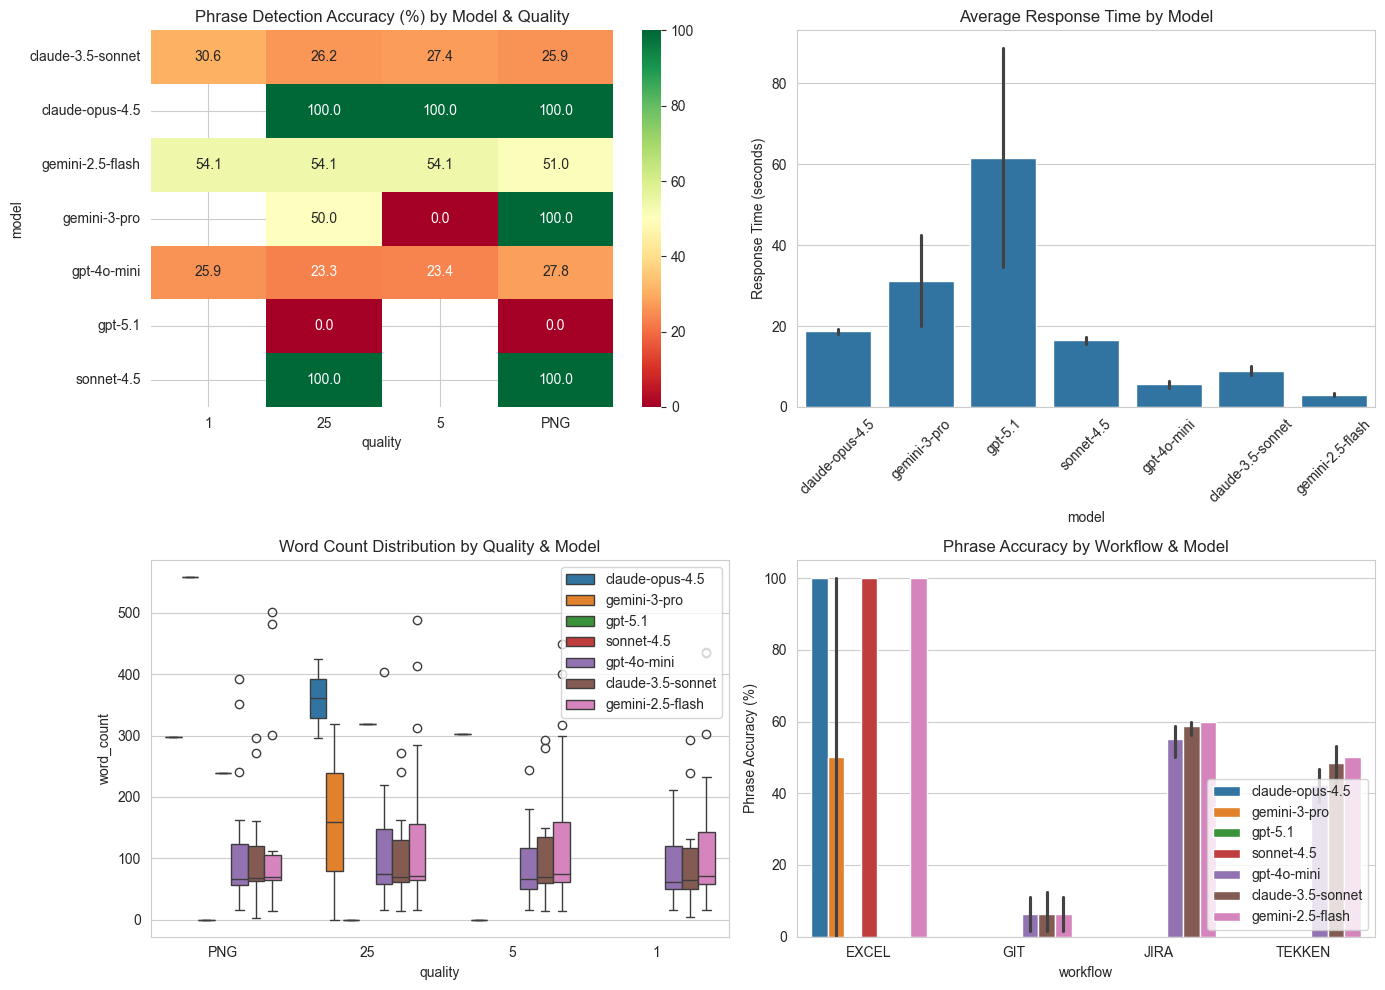


✓ Charts saved to c:\Users\Matthew Feroz\Desktop\ALIVEOCR\ALIVEData\research\ocr_comparison_charts.png


In [11]:
# Cell 10: Visualizations

def plot_results(df: pd.DataFrame):
    """Generate comparison visualizations."""
    
    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = [12, 8]
    
    # Filter out errors
    df_clean = df[df['error'].isna()].copy()
    
    if len(df_clean) == 0:
        print("No successful results to visualize")
        return
    
    # 1. Phrase Accuracy by Model and Quality
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Phrase accuracy heatmap
    ax1 = axes[0, 0]
    pivot = df_clean.pivot_table(
        values='phrase_accuracy', 
        index='model', 
        columns='quality', 
        aggfunc='mean'
    )
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax1, vmin=0, vmax=100)
    ax1.set_title('Phrase Detection Accuracy (%) by Model & Quality')
    
    # Response time by model
    ax2 = axes[0, 1]
    sns.barplot(data=df_clean, x='model', y='response_time_s', ax=ax2)
    ax2.set_title('Average Response Time by Model')
    ax2.set_ylabel('Response Time (seconds)')
    ax2.tick_params(axis='x', rotation=45)
    
    # Word count by quality
    ax3 = axes[1, 0]
    sns.boxplot(data=df_clean, x='quality', y='word_count', hue='model', ax=ax3)
    ax3.set_title('Word Count Distribution by Quality & Model')
    ax3.legend(loc='upper right')
    
    # Phrase accuracy by workflow
    ax4 = axes[1, 1]
    sns.barplot(data=df_clean, x='workflow', y='phrase_accuracy', hue='model', ax=ax4)
    ax4.set_title('Phrase Accuracy by Workflow & Model')
    ax4.set_ylabel('Phrase Accuracy (%)')
    ax4.legend(loc='lower right')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'ocr_comparison_charts.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Charts saved to {RESULTS_DIR / 'ocr_comparison_charts.png'}")

# Run visualization if results exist
if 'results_df' in dir() and len(results_df) > 0:
    plot_results(results_df)
else:
    print("Run the comparison first (Cell 8) to generate visualizations")

In [12]:
# Cell 11: Summary Statistics

def generate_summary(df: pd.DataFrame) -> pd.DataFrame:
    """Generate summary statistics for the paper."""
    
    df_clean = df[df['error'].isna()].copy()
    
    summary = df_clean.groupby(['model', 'quality']).agg({
        'phrase_accuracy': ['mean', 'std'],
        'word_count': ['mean', 'std'],
        'response_time_s': ['mean', 'std'],
        'file_size_kb': 'mean'
    }).round(2)
    
    summary.columns = ['_'.join(col).strip() for col in summary.columns]
    
    return summary

if 'results_df' in dir() and len(results_df) > 0:
    summary = generate_summary(results_df)
    print("Summary Statistics:")
    print(summary)
    
    # Save to CSV for the paper
    summary.to_csv(RESULTS_DIR / 'ocr_summary_statistics.csv')
    print(f"\n✓ Summary saved to {RESULTS_DIR / 'ocr_summary_statistics.csv'}")
else:
    print("Run the comparison first (Cell 8)")

Summary Statistics:
                           phrase_accuracy_mean  phrase_accuracy_std  \
model             quality                                              
claude-3.5-sonnet 1                       30.62                29.60   
                  25                      26.18                26.67   
                  5                       27.35                27.73   
                  PNG                     25.94                28.00   
claude-opus-4.5   25                     100.00                 0.00   
                  5                      100.00                  NaN   
                  PNG                    100.00                  NaN   
gemini-2.5-flash  1                       54.06                34.89   
                  25                      54.06                34.89   
                  5                       54.06                34.89   
                  PNG                     51.00                33.82   
gemini-3-pro      25                      50